In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


In [2]:
# --- Input files in the "New Cube Sensors" folder ---
cube1_file = "New Cube Sensors/25.05.02_CUBE 1 (mobile).csv"
cube6_file = "New Cube Sensors/25.05.02_CUBE 6.csv"
cube_ice_file = "New Cube Sensors/25.05.02_CUBE ICE.csv"

# --- Time ranges and corresponding file ---
time_slots = [
    ("09:00:00", "09:15:00", cube1_file),
    ("09:30:00", "09:45:00", cube_ice_file),
    ("09:50:00", "10:05:00", cube1_file),
    ("10:10:00", "10:25:00", cube6_file),
    ("10:30:00", "10:45:00", cube6_file),
    ("11:00:00", "11:15:00", cube1_file),
    ("11:15:00", "11:30:00", cube1_file),
]


In [3]:
# --- Helper: convert "HH:MM:SS" string to datetime.time object ---
def str_to_time(t_str):
    try:
        return datetime.strptime(t_str.strip(), "%H:%M:%S").time()
    except:
        return None

# --- Helper: convert to HH:MM string (pad hour if needed) ---
def normalize_to_HHMM(t_str):
    try:
        t = datetime.strptime(t_str.strip(), "%H:%M:%S")
        return t.strftime("%H:%M")
    except:
        return None

# --- Generalized function to extract any column (e.g. PMV, SET) ---
def get_column_for_range(file, column_name, start_str, end_str):
    df = pd.read_csv(file)

    time_col = ' HH:MM:SS'
    value_col = column_name

    # Convert time column to time objects
    df['__time_obj__'] = df[time_col].apply(str_to_time)

    # Time range bounds
    t_start = str_to_time(start_str)
    t_end = str_to_time(end_str)

    # Filter and return relevant data
    df_valid = df[df['__time_obj__'].notna()]
    df_filtered = df_valid[
        (df_valid['__time_obj__'] >= t_start) &
        (df_valid['__time_obj__'] <= t_end)
    ]

    return df_filtered[[time_col, value_col]].rename(columns={time_col: 'Time', value_col: 'Value'})


In [4]:
# ================================
# === PMV Extraction & Plotting ===
# ================================

all_pmv = []

for start, end, file in time_slots:
    print(f"📂 Extracting PMV from {file} ({start}–{end})")
    pmv_data = get_column_for_range(file, ' PMV ASHRAE-55', start, end)
    all_pmv.append(pmv_data)

df_pmv = pd.concat(all_pmv, ignore_index=True)
df_pmv['Minute'] = df_pmv['Time'].apply(normalize_to_HHMM)
df_pmv = df_pmv[df_pmv['Minute'].notna()]
df_pmv['Value'] = pd.to_numeric(df_pmv['Value'], errors='coerce')

df_pmv_avg = df_pmv.groupby('Minute')['Value'].mean().reset_index()
df_pmv_avg['Minute'] = pd.to_datetime(df_pmv_avg['Minute'], format="%H:%M")
df_pmv_avg = df_pmv_avg.sort_values('Minute')
df_pmv_avg['Minute'] = df_pmv_avg['Minute'].dt.strftime("%H:%M")
df_pmv_avg.to_csv("pmv_per_minute.csv", index=False)
print("✅ PMV saved to pmv_per_minute.csv")


📂 Extracting PMV from New Cube Sensors/25.05.02_CUBE 1 (mobile).csv (09:00:00–09:15:00)
📂 Extracting PMV from New Cube Sensors/25.05.02_CUBE ICE.csv (09:30:00–09:45:00)
📂 Extracting PMV from New Cube Sensors/25.05.02_CUBE 1 (mobile).csv (09:50:00–10:05:00)
📂 Extracting PMV from New Cube Sensors/25.05.02_CUBE 6.csv (10:10:00–10:25:00)
📂 Extracting PMV from New Cube Sensors/25.05.02_CUBE 6.csv (10:30:00–10:45:00)
📂 Extracting PMV from New Cube Sensors/25.05.02_CUBE 1 (mobile).csv (11:00:00–11:15:00)
📂 Extracting PMV from New Cube Sensors/25.05.02_CUBE 1 (mobile).csv (11:15:00–11:30:00)
✅ PMV saved to pmv_per_minute.csv


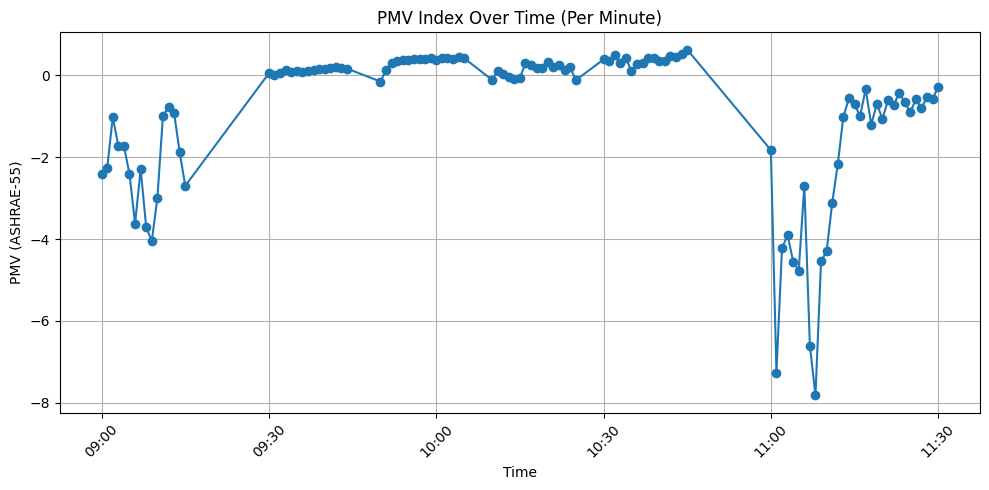

In [5]:
# Plot PMV
df_plot_pmv = pd.read_csv("pmv_per_minute.csv")
df_plot_pmv['Minute'] = pd.to_datetime(df_plot_pmv['Minute'], format="%H:%M")

plt.figure(figsize=(10, 5))
plt.plot(df_plot_pmv['Minute'], df_plot_pmv['Value'], marker='o', linestyle='-', label='PMV')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.title("PMV Index Over Time (Per Minute)")
plt.xlabel("Time")
plt.ylabel("PMV (ASHRAE-55)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [6]:
# ================================
# === SET Extraction & Plotting ===
# ================================

all_set = []

for start, end, file in time_slots:
    print(f"📂 Extracting SET from {file} ({start}–{end})")
    set_data = get_column_for_range(file, ' STANDARD EFFECTIVE TEMP (*C)', start, end)
    all_set.append(set_data)

df_set = pd.concat(all_set, ignore_index=True)
df_set['Minute'] = df_set['Time'].apply(normalize_to_HHMM)
df_set = df_set[df_set['Minute'].notna()]
df_set['Value'] = pd.to_numeric(df_set['Value'], errors='coerce')

df_set_avg = df_set.groupby('Minute')['Value'].mean().reset_index()
df_set_avg['Minute'] = pd.to_datetime(df_set_avg['Minute'], format="%H:%M")
df_set_avg = df_set_avg.sort_values('Minute')
df_set_avg['Minute'] = df_set_avg['Minute'].dt.strftime("%H:%M")
df_set_avg.to_csv("set_per_minute.csv", index=False)
print("✅ SET saved to set_per_minute.csv")


📂 Extracting SET from New Cube Sensors/25.05.02_CUBE 1 (mobile).csv (09:00:00–09:15:00)
📂 Extracting SET from New Cube Sensors/25.05.02_CUBE ICE.csv (09:30:00–09:45:00)
📂 Extracting SET from New Cube Sensors/25.05.02_CUBE 1 (mobile).csv (09:50:00–10:05:00)
📂 Extracting SET from New Cube Sensors/25.05.02_CUBE 6.csv (10:10:00–10:25:00)
📂 Extracting SET from New Cube Sensors/25.05.02_CUBE 6.csv (10:30:00–10:45:00)
📂 Extracting SET from New Cube Sensors/25.05.02_CUBE 1 (mobile).csv (11:00:00–11:15:00)
📂 Extracting SET from New Cube Sensors/25.05.02_CUBE 1 (mobile).csv (11:15:00–11:30:00)
✅ SET saved to set_per_minute.csv


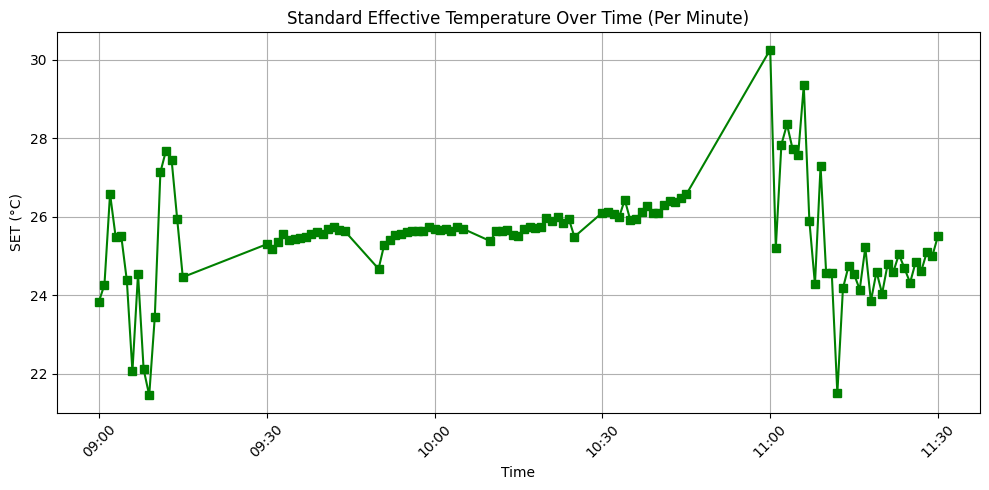

In [7]:
# Plot SET
df_plot_set = pd.read_csv("set_per_minute.csv")
df_plot_set['Minute'] = pd.to_datetime(df_plot_set['Minute'], format="%H:%M")

plt.figure(figsize=(10, 5))
plt.plot(df_plot_set['Minute'], df_plot_set['Value'], marker='s', linestyle='-', color='green', label='SET')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.title("Standard Effective Temperature Over Time (Per Minute)")
plt.xlabel("Time")
plt.ylabel("SET (°C)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

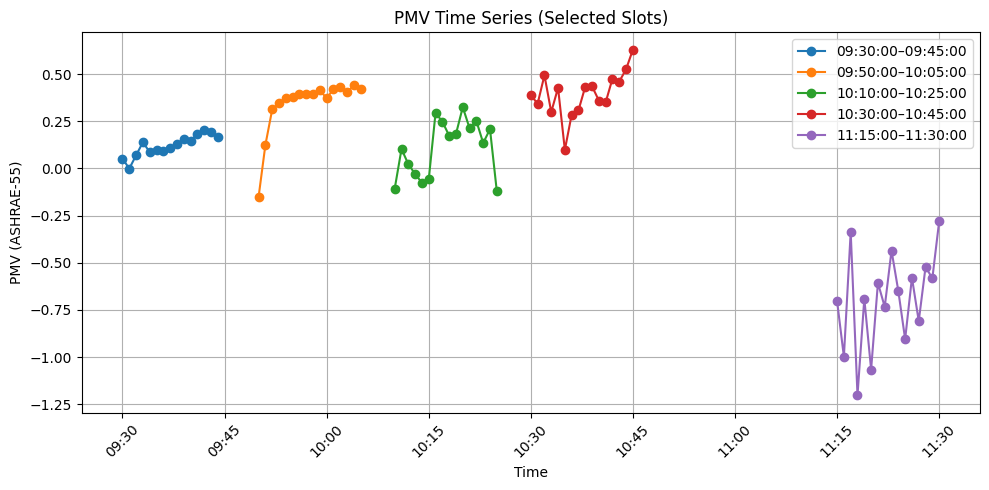

In [8]:
# --- Load PMV data ---
df_pmv = pd.read_csv("pmv_per_minute.csv")
df_pmv['Minute'] = pd.to_datetime(df_pmv['Minute'], format="%H:%M")

# --- Define selected time slots ---
selected_slots = [
    ("09:30:00", "09:45:00"),
    ("09:50:00", "10:05:00"),
    ("10:10:00", "10:25:00"),
    ("10:30:00", "10:45:00"),
    ("11:15:00", "11:30:00"),
]

# --- Plot ---
plt.figure(figsize=(10, 5))

for start_str, end_str in selected_slots:
    t_start = datetime.strptime(start_str, "%H:%M:%S").time()
    t_end = datetime.strptime(end_str, "%H:%M:%S").time()
    
    mask = df_pmv['Minute'].dt.time.between(t_start, t_end)
    df_slot = df_pmv[mask]
    
    plt.plot(df_slot['Minute'], df_slot['Value'], marker='o', label=f"{start_str}–{end_str}")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.title("PMV Time Series (Selected Slots)")
plt.xlabel("Time")
plt.ylabel("PMV (ASHRAE-55)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
